# Load data
Load test result dataframes with added loss function binary indicators

In [2]:
import pandas as pd

def add_loss_columns(csv_path, model_name_column='model_name'):
    """
    Lädt eine CSV-Datei, liest die Modellnamen und erstellt binäre Spalten für enthaltene Loss-Funktionen.
    
    Args:
        csv_path (str): Pfad zur CSV-Datei.
        model_name_column (str): Name der Spalte, die den Modellnamen enthält.
        
    Returns:
        pd.DataFrame: Der erweiterte DataFrame mit binären Spalten für Loss-Funktionen.
    """
    # Definierbare Liste bekannter Loss-Komponenten (du kannst diese erweitern)
    known_losses = ['ITM', 'SimCLR', 'MLM', 'CLIP']

    # CSV laden
    df = pd.read_csv(csv_path)

    # Modellnamen in Großbuchstaben für robustere Erkennung
    model_names = df[model_name_column].fillna("").str.upper()

    # Binärspalten hinzufügen
    for loss in known_losses:
        df[loss] = model_names.str.contains(loss.upper()).astype(int)

    return df


In [3]:
df_zeroshot = add_loss_columns("/home/phisch/multimodal/test_results/model_scores_zero-shot.csv", model_name_column="model_name")
df_probe = add_loss_columns("/home/phisch/multimodal/test_results/model_scores_linear_probe.csv", model_name_column="model_name")
df_retrieval = add_loss_columns("/home/phisch/multimodal/test_results/model_scores_retrieval.csv", model_name_column="model")

# Univariate loss analysis
Compute mean test scores for models with vs. without a loss function

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def univariate_loss_analysis(
    df,
    loss_columns,
    score_column="score",
    task_label="zeroshot",
    metric_filter="Top1Accuracy",
    method_notes=None,
    dataset_fraction=None
):
    """
    Führt eine univariate Analyse für jede Loss-Funktion durch – mit optionalem Filtering.

    Args:
        df (pd.DataFrame): DataFrame mit Modell-Leistungen und binären Loss-Spalten.
        loss_columns (list of str): Spaltennamen der Loss-Funktionen (binär kodiert).
        score_column (str): Spalte mit Scores, z. B. Accuracy.
        task_label (str): Für Plot-Titel und Anzeige.
        metric_filter (str): Metrik, die analysiert werden soll.
        method_notes (str or None): Optionaler Filter für 'method_notes'.
        dataset_fraction (str or None): Optionaler Filter für 'dataset_fraction'.

    Returns:
        pd.DataFrame mit Mittelwerten für jede Loss-Funktion (mit und ohne).
        Zusätzlich: Boxplots je Loss-Funktion.
    """
    df_filtered = df[df["metric"] == metric_filter].copy()

    if method_notes is not None:
        df_filtered = df_filtered[df_filtered["method_notes"] == method_notes]

    if dataset_fraction is not None:
        df_filtered = df_filtered[df_filtered["dataset_fraction"] == dataset_fraction]

    print(f"\n📊 Univariate Analyse für {task_label} ({metric_filter})")
    print(f"→ Filter: method_notes = {method_notes}, dataset_fraction = {dataset_fraction}")
    print(f"→ Anzahl ausgewählter Zeilen: {len(df_filtered)}\n")

    results = []

    for loss in loss_columns:
        if loss not in df_filtered.columns:
            continue

        group_means = df_filtered.groupby(loss)[score_column].mean()
        diff = group_means.get(1, float('nan')) - group_means.get(0, float('nan'))

        results.append({
            "loss_function": loss,
            "mean_with": group_means.get(1, float('nan')),
            "mean_without": group_means.get(0, float('nan')),
            "difference": diff
        })

        # Visualisierung
        sns.boxplot(data=df_filtered, x=loss, y=score_column)
        plt.title(f"{task_label} – Einfluss von {loss}")
        plt.xticks([0, 1], ['Ohne', 'Mit'])
        plt.xlabel(loss)
        plt.ylabel(metric_filter)
        plt.show()

    results = pd.DataFrame(results).sort_values(by="difference", ascending=False)
    return results


## Box plots


📊 Univariate Analyse für Zero-Shot (Top1Accuracy)
→ Filter: method_notes = 1_templates, dataset_fraction = 1-aug
→ Anzahl ausgewählter Zeilen: 156



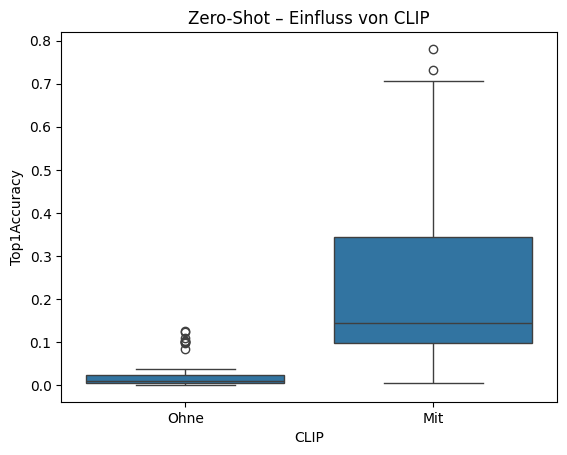

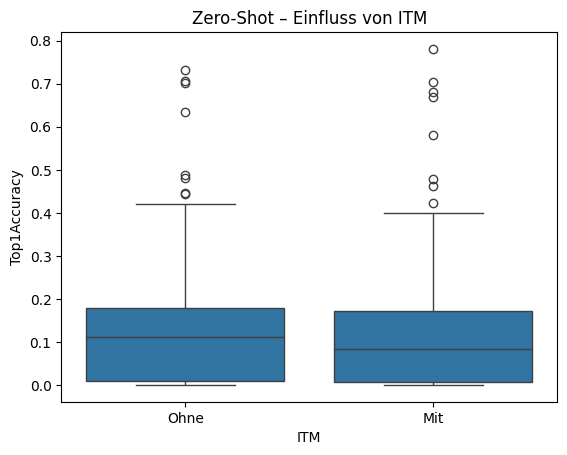

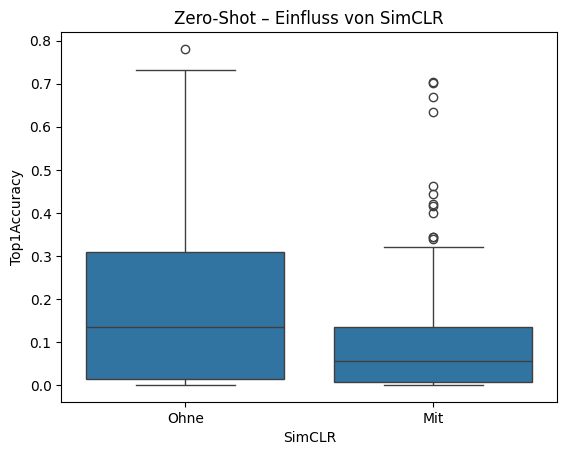

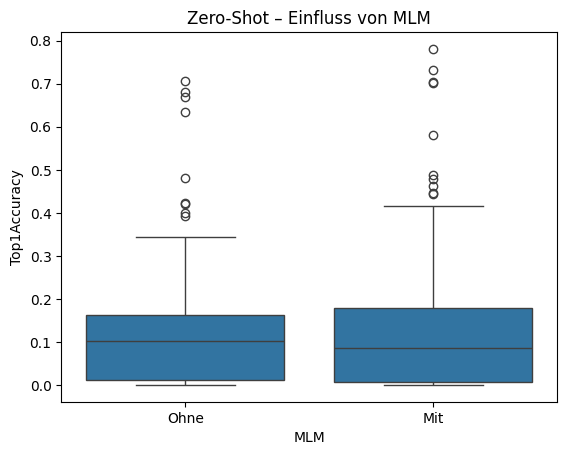

In [8]:
loss_columns = ["CLIP", "ITM", "SimCLR", "MLM"]

df_results_zeroshot = univariate_loss_analysis(
    df_zeroshot,
    loss_columns=loss_columns,
    task_label="Zero-Shot",
    metric_filter="Top1Accuracy",
    method_notes="1_templates",
    dataset_fraction="1-aug"
)



📊 Univariate Analyse für Linear Probe (Top1Accuracy)
→ Filter: method_notes = last_image_layer, dataset_fraction = 1-aug
→ Anzahl ausgewählter Zeilen: 169



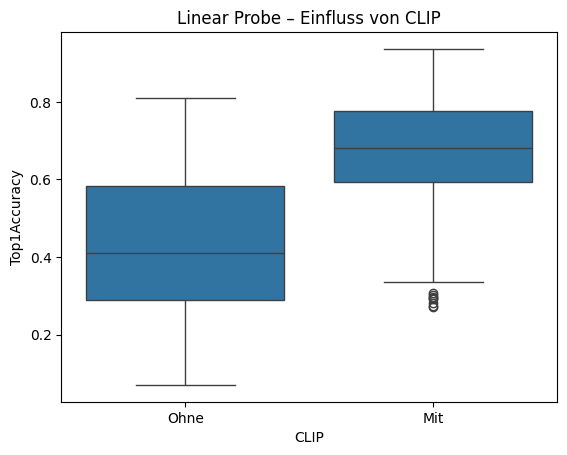

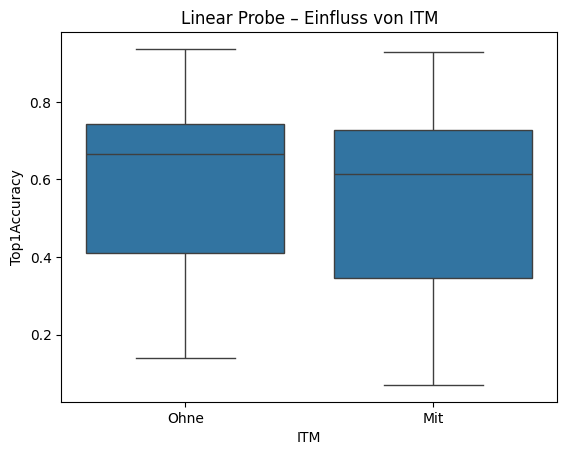

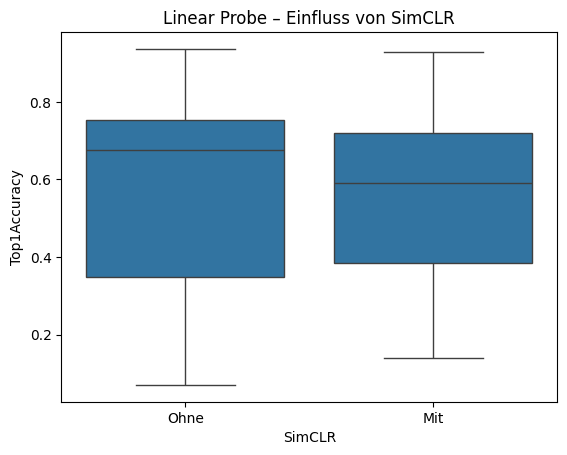

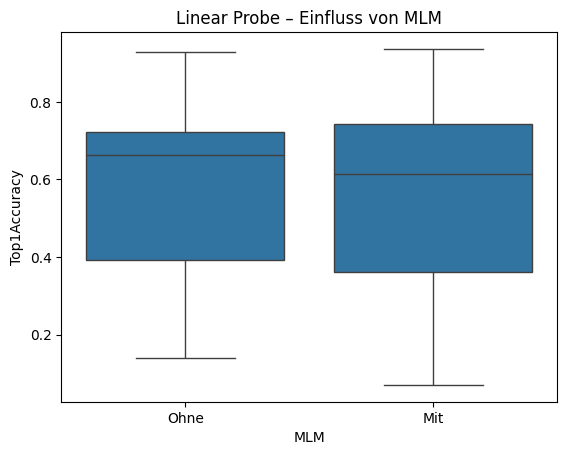

In [9]:
df_results_probe = univariate_loss_analysis(
    df_probe,
    loss_columns=loss_columns,
    task_label="Linear Probe",
    metric_filter="Top1Accuracy",
    method_notes="last_image_layer",
    dataset_fraction="1-aug"
)

In [10]:
def univariate_retrieval_analysis(
    df,
    loss_columns,
    score_columns,  # z.B. ["text_retrieval_recall@1", "image_retrieval_recall@5"]
    task_label="zeroshot_retrieval",
    dataset_fraction=None,
):
    """
    Führt univariate Analyse für jede Loss-Funktion in einem Retrieval-DataFrame durch.
    Jeder Score ist eine eigene Spalte.

    Args:
        df (pd.DataFrame): Retrieval DataFrame.
        loss_columns (list of str): Binäre Spalten für Loss-Funktionen.
        score_columns (list of str): Score-Spalten (Recall@k).
        task_label (str): Für Plot-Titel etc.

    Returns:
        pd.DataFrame mit Mittelwerten je Loss-Funktion & Score-Spalte.
        Zusätzlich: Boxplots.
    """
    print(f"\n📊 Univariate Analyse für Retrieval ({task_label})")
    print(f"→ Score-Metriken: {score_columns}")
    print(f"→ Zeilen: {len(df)}\n")

    if dataset_fraction is not None:
        df = df[df["model"].str.contains(dataset_fraction)]

    results = []

    for loss in loss_columns:
        if loss not in df.columns:
            continue

        for metric in score_columns:
            if metric not in df.columns:
                continue

            group_means = df.groupby(loss)[metric].mean()
            diff = group_means.get(1, float('nan')) - group_means.get(0, float('nan'))

            results.append({
                "loss_function": loss,
                "metric": metric,
                "mean_with": group_means.get(1, float('nan')),
                "mean_without": group_means.get(0, float('nan')),
                "difference": diff
            })

            # Visualisierung
            sns.boxplot(data=df, x=loss, y=metric)
            plt.title(f"{task_label} – {metric} vs. {loss}")
            plt.xticks([0, 1], ['Ohne', 'Mit'])
            plt.xlabel(loss)
            plt.ylabel(metric)
            plt.show()

    return pd.DataFrame(results).sort_values(by="difference", ascending=False)



📊 Univariate Analyse für Retrieval (Zero-shot Retrieval)
→ Score-Metriken: ['text_retrieval_recall@1', 'image_retrieval_recall@1']
→ Zeilen: 183



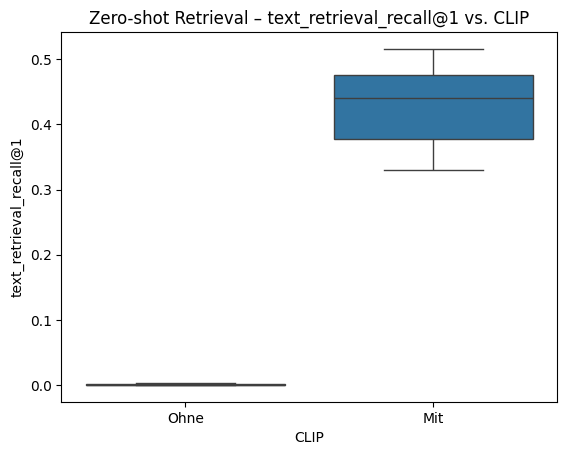

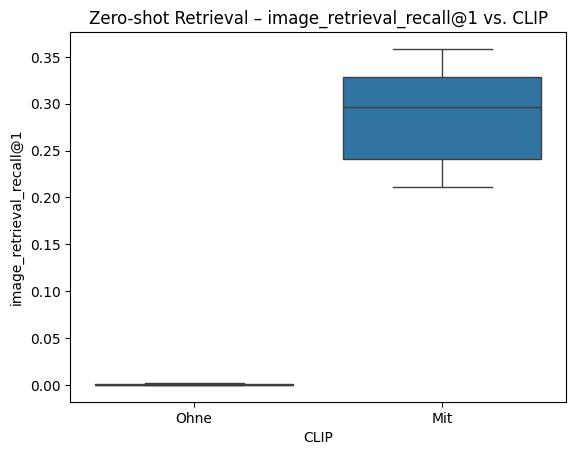

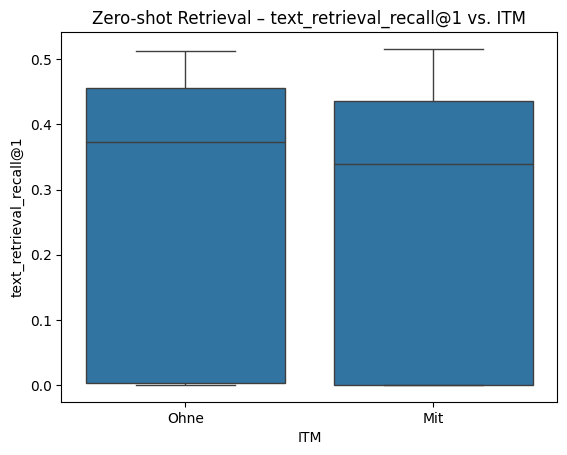

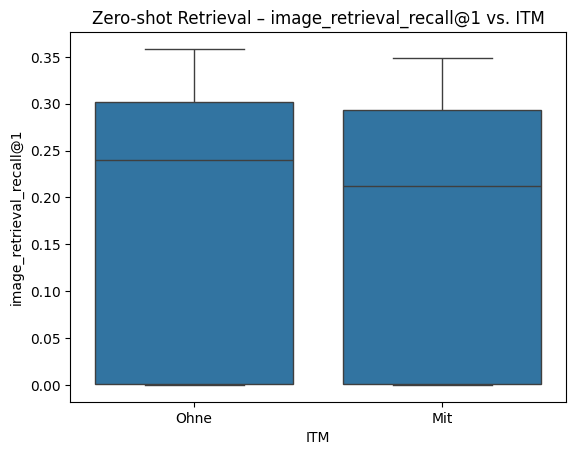

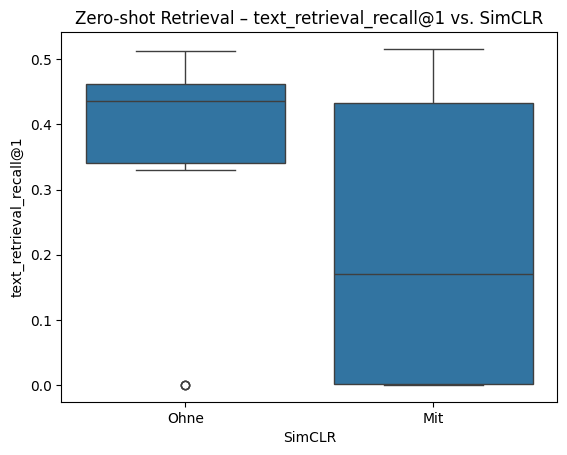

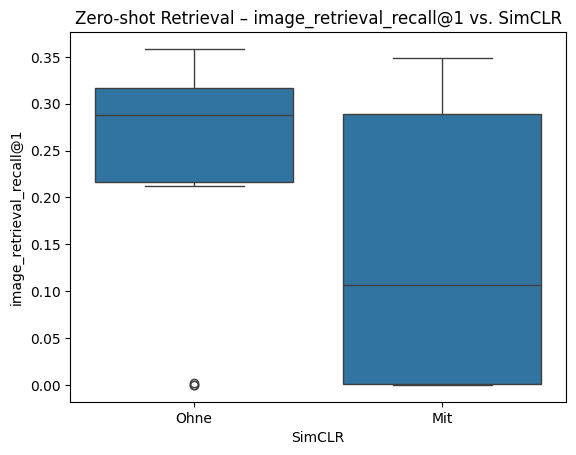

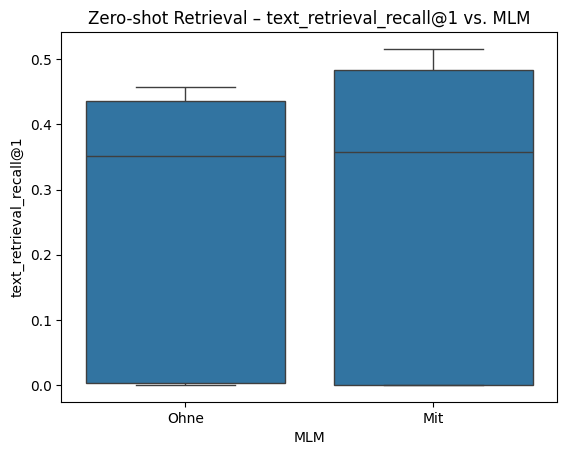

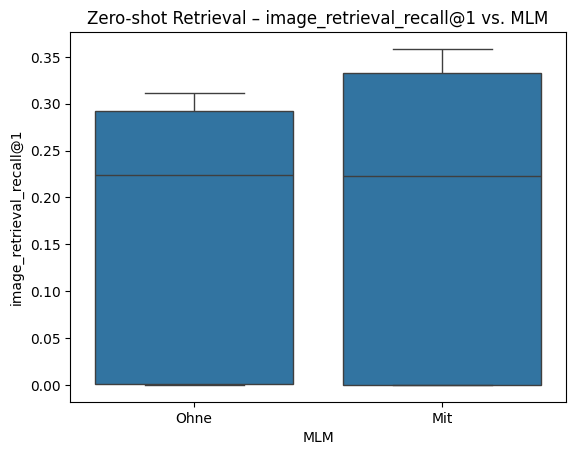

In [11]:
retrieval_metrics = [
    "text_retrieval_recall@1",
    # "text_retrieval_recall@5",
    # "text_retrieval_recall@10",
    "image_retrieval_recall@1",
    # "image_retrieval_recall@5",
    # "image_retrieval_recall@10"
]

loss_columns = ["CLIP", "ITM", "SimCLR", "MLM"]

df_retrieval_results = univariate_retrieval_analysis(
    df_retrieval,
    loss_columns=loss_columns,
    score_columns=retrieval_metrics,
    task_label="Zero-shot Retrieval",
    dataset_fraction="1-aug"
)


## Bar plots

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_difference_bar(df, title="Einfluss einzelner Loss-Funktionen"):
    """
    Erstellt ein Barplot für den Unterschied (mean_with - mean_without) jeder Loss-Funktion.
    """
    df_sorted = df.sort_values("difference", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_sorted, x="difference", y="loss_function", palette="coolwarm", orient="h")
    plt.axvline(0, color="gray", linestyle="--")
    plt.xlabel("Ø Unterschied (mit vs. ohne)")
    plt.ylabel("Loss-Funktion")
    plt.title(title)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_679080/1697856811.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x="difference", y="loss_function", palette="coolwarm", orient="h")


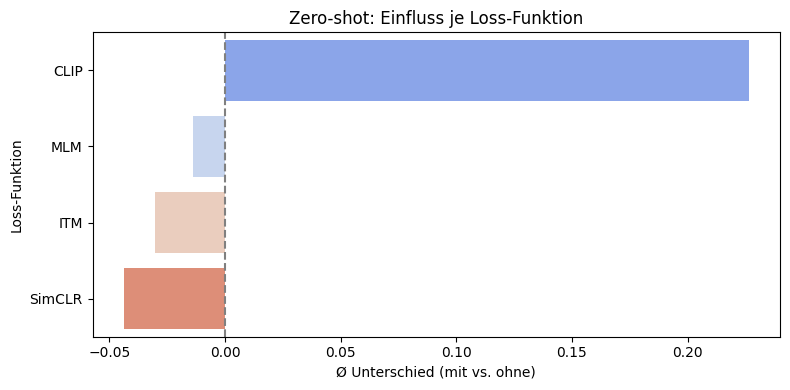

In [13]:
plot_loss_difference_bar(df_results_probe, title="Zero-shot: Einfluss je Loss-Funktion")

In [1]:
def plot_loss_mean_comparison(df, title="Vergleich: mit vs. ohne Loss-Funktion"):
    """
    Erstellt ein gruppiertes Balkendiagramm der Mittelwerte mit und ohne jede Loss-Funktion.
    """
    melted = df.melt(id_vars="loss_function", value_vars=["mean_with", "mean_without"],
                     var_name="Bedingung", value_name="Score")

    # Optional: schönere Achsenbeschriftungen
    melted["Bedingung"] = melted["Bedingung"].map({
        "mean_with": "mit Loss",
        "mean_without": "ohne Loss"
    })

    plt.figure(figsize=(9, 5))
    sns.barplot(data=melted, x="Score", y="loss_function", hue="Bedingung", palette="Set2")
    plt.xlabel("Ø Score")
    plt.ylabel("Loss-Funktion")
    plt.title(title)
    plt.tight_layout()
    plt.show()


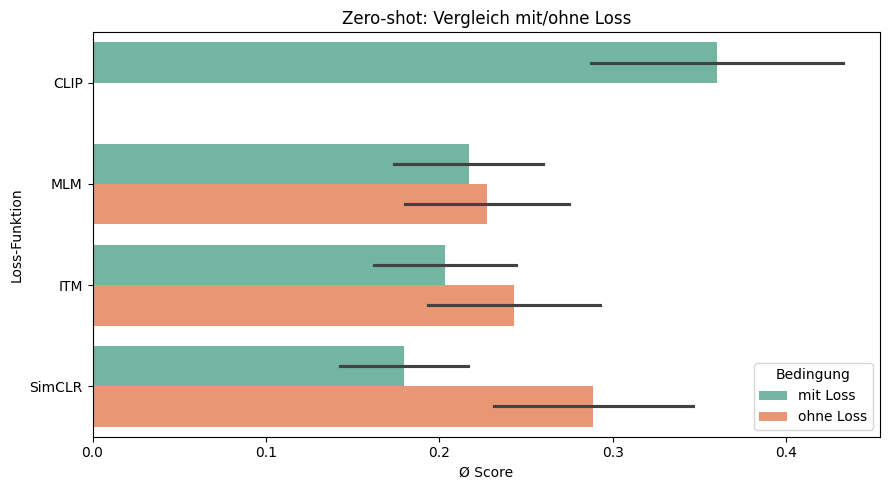

In [16]:
plot_loss_mean_comparison(df_retrieval_results, title="Zero-shot: Vergleich mit/ohne Loss")

## Heatmap
Loss functions vs Task

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_heatmap_with_retrieval_subtasks(dfs_by_task):
    """
    Erwartet dict mit keys 'Zero-Shot', 'Probing', 'Retrieval' und DataFrames als values.
    Für Retrieval wird nach 'metric' unterschieden in Text- und Image-Retrieval.
    """
    all_differences = []

    for task_name, df in dfs_by_task.items():
        if task_name == "Retrieval":
            # Für Retrieval: Subtasks nach 'metric' aufteilen
            for _, row in df.iterrows():
                if 'text_retrieval' in row['metric']:
                    subtask = "Retrieval (Text)"
                elif 'image_retrieval' in row['metric']:
                    subtask = "Retrieval (Image)"
                else:
                    subtask = "Retrieval (Other)"
                
                all_differences.append({
                    "task": subtask,
                    "loss_function": row["loss_function"],
                    "difference": row["difference"]
                })
        else:
            # Für Zero-Shot und Probing kein Subtask
            for _, row in df.iterrows():
                all_differences.append({
                    "task": task_name,
                    "loss_function": row["loss_function"],
                    "difference": row["difference"]
                })

    combined_df = pd.DataFrame(all_differences)

    heatmap_data = combined_df.pivot(index='loss_function', columns='task', values='difference')

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".3f",
                linewidths=0.5, linecolor='grey')
    plt.title("Performance-Differenz durch Loss-Funktion je Aufgabe")
    plt.ylabel("Loss-Funktion")
    plt.xlabel("Aufgabe / Subtask")
    plt.tight_layout()
    plt.show()


In [19]:
df_retrieval_results

,loss_function,metric,mean_with,mean_without,difference
0,CLIP,text_retrieval_recall@1,0.432450,0.000920,0.431530
1,CLIP,image_retrieval_recall@1,0.287152,0.000565,0.286586
7,MLM,image_retrieval_recall@1,0.174087,0.180238,-0.006151
6,MLM,text_retrieval_recall@1,0.259533,0.274578,-0.015044
3,ITM,image_retrieval_recall@1,0.162562,0.193684,-0.031122
2,ITM,text_retrieval_recall@1,0.244181,0.292489,-0.048308
5,SimCLR,image_retrieval_recall@1,0.142767,0.231581,-0.088814
4,SimCLR,text_retrieval_recall@1,0.216725,0.346080,-0.129355


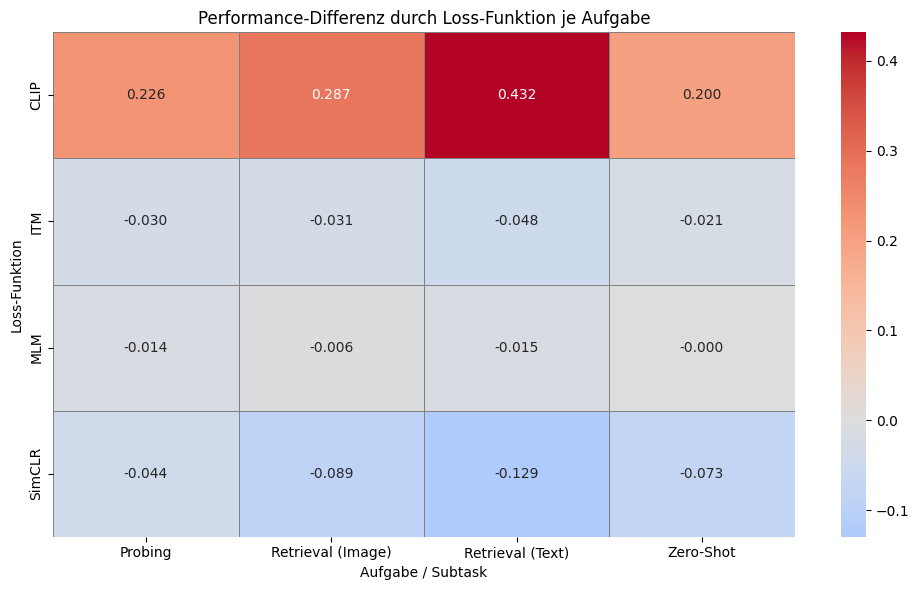

In [22]:
dfs_by_task = {
    "Zero-Shot": df_results_zeroshot,
    "Probing": df_results_probe,
    "Retrieval": df_retrieval_results
}

create_heatmap_with_retrieval_subtasks(dfs_by_task)
